In [1]:
import sys
!pip install torch torchvision torchtext pytorch_lightning tensorboard matplotlib tqdm wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import urllib.request
import os
if not os.path.exists("Alpine Land Cover.zip"):
    print(f"downloading Alpine Land Cover.zip")
    urllib.request.urlretrieve("https://enacshare.epfl.ch/fQHAmeKDY6vnMxiEFRzyaP7csVXfNtg", "Alpine_Land_Cover.zip")

import zipfile
with zipfile.ZipFile("Alpine_Land_Cover.zip", 'r') as zip_ref:
    zip_ref.extractall()

downloading Alpine Land Cover.zip


In [4]:
import urllib.request
import os
imgName = os.path.join('ipeo_data/alpine_label/', '25566_11089_label.tif') 
imgName2 = os.path.join('ipeo_data/rgb/', '25566_11089_rgb.tif') 

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

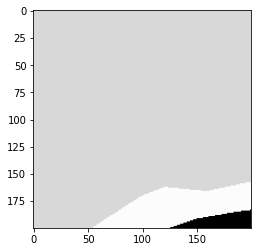

In [6]:
imgLabel = Image.open(imgName)
img = Image.open(imgName2)
img=img.resize((200,200))
img = img.convert("RGBA")
#lt.imshow(img)

pimg = np.array(imgLabel)
#print(pimg*36)
image3 = Image.fromarray(pimg*36)
rgb_im = image3.convert("RGBA")
blended_image = Image.blend(img, rgb_im, 1)
plt.imshow(blended_image)

In [7]:
from torch.utils.data import Dataset

import csv
from PIL import Image
import torchvision.transforms as T
import torch

import os
import glob

default_transform =  T.Compose([
        T.Resize((200, 200)),
        T.ToTensor()])

class LandCoverData(Dataset):

    # mapping between label class names and indices
    LABEL_CLASSES = {
      'Grass and other': 0,
      'Wald': 1,
      'Bushes and sparse forest': 2,
      'Water and wetlands': 3,
      'Glaciers and permanent snow': 4,
      'Sparse rocks (rocks mixed with grass)': 5,
      'Loose rocks, scree': 6,
      'Bed rocks': 7
    }

    label_transform = T.ToTensor()

    def __init__(self, transforms=None, split='train', ):
        self.transforms = transforms

        # prepare data
        self.data = []     

        with open(f'ipeo_data/splits/{split}.csv', newline='') as csvfile:
          csvReader = csv.reader(csvfile, delimiter=' ', quotechar='|')
          for row in csvReader:
              #print(row)
              rowStr=row[0]
              if (rowStr=="25595_11025"):
                continue
              imgNameRGB = os.path.join('ipeo_data/rgb/', f'{rowStr}_rgb.tif')
              imgNameLabel = os.path.join('ipeo_data/alpine_label/', f'{rowStr}_label.tif')
              self.data.append((
                  imgNameRGB,
                  imgNameLabel
              ))

    #TODO: please provide the remaining functions required for the torch.utils.data.Dataset class.
    def __len__(self):
        return len(self.data)


    def __getitem__(self, x):
        imgName, imgLabel = self.data[x]

        img = Image.open(imgName)
        label = Image.open(imgLabel)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, self.label_transform(label)

In [8]:
train_dataset = LandCoverData(transforms=default_transform, split="train")
val_dataset = LandCoverData(transforms=default_transform, split="val")

In [9]:
import torch
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# TODO create a training data dataloader with the specifications above
train_dl = DataLoader(train_dataset, BATCH_SIZE, True, num_workers=2)
# num_workers 8 default but 2 on colab
val_dl = DataLoader(val_dataset, BATCH_SIZE, False, num_workers=2)

In [10]:
# import the necessary packages
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import BatchNorm2d
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [11]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.batchNorm = BatchNorm2d(outChannels)
		self.relu = ReLU()
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.relu(self.batchNorm(self.conv1(x)))

In [12]:
class Encoder(Module):
	def __init__(self, channels=(3,64,128,256,512,1024)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encoderStep = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(kernel_size=3, stride=2)
	
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for step in self.encoderStep:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = step(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [13]:
class Decoder(Module):
	def __init__(self, channels=(1024, 512, 256, 128, 64)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.fusingConvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.decoderStep = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.fusingConvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block

			# STACKING
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)

			x = self.decoderStep[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [14]:
INPUT_IMAGE_HEIGHT=200
INPUT_IMAGE_WIDTH=200

In [15]:
class UNet(Module):
  def __init__(self, encChannels=(3,64,128,256,512,1024),
		 decChannels=(1024, 512, 256, 128, 64),
		 nbClasses=1, retainDim=True,
		 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
      super().__init__()
      # initialize the encoder and decoder
      self.encoder = Encoder(encChannels)
      self.decoder = Decoder(decChannels)
      # initialize the regression head and store the class variables
      self.head = Conv2d(decChannels[-1], nbClasses, 1)
      self.retainDim = retainDim
      self.outSize = outSize

  def forward(self, x):
      # grab the features from the encoder
      encFeatures = self.encoder(x)
      # pass the encoder features through decoder making sure that
      # their dimensions are suited for concatenation
      decFeatures = self.decoder(encFeatures[::-1][0],
        encFeatures[::-1][1:])
      # pass the decoder features through the regression head to
      # obtain the segmentation mask
      map = self.head(decFeatures)
      # check to see if we are retaining the original output
      # dimensions and if so, then resize the output to match them
      if self.retainDim:
        map = F.interpolate(map, self.outSize)
      # return the segmentation map
      return map

In [16]:
from torch.nn import CrossEntropyLoss
from torch.nn import BCELoss
from torch.nn import MSELoss

from torch.optim import Adam
from torch.optim import SGD
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time

In [ ]:
#!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# To reset the GPU load
#from numba import cuda
# all of your code and execution
#device = cuda.get_current_device() 
#device.reset()

In [25]:
DEVICE = "cuda"
INIT_LR = 0.001
INIT_MOMENTUM = 0.9
NUM_EPOCHS = 10

In [26]:
# initialize our UNet model
unet = UNet(nbClasses=8).to(DEVICE)
# initialize loss function and optimizer
lossFunc = CrossEntropyLoss()
opt = SGD(unet.parameters(), lr=INIT_LR, momentum=INIT_MOMENTUM)
# calculate steps per epoch for training and test set
trainSteps = len(train_dataset) // BATCH_SIZE
testSteps = len(val_dataset) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
# ECLATE 25595_11025_label.tif

In [27]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
#for e in tqdm(range(NUM_EPOCHS)):
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(train_dl):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        #probs = torch.softmax(pred, dim=1)
        #preds = torch.argmax(probs, dim=1).unsqueeze(1)
        #preds=preds.to(torch.float32)
        #print(y)
        y = y.to(torch.long)
        y = y.squeeze()
        #print(pred.shape)
        #print(x.shape)
        #print(y.shape)
        #print(pred.unsqueeze(1).shape)
        #print(pred)
        #print(y)
        #raise Exception("oui")
        
        loss = lossFunc(pred, y)
        
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in val_dl:
          # send the input to the device
          (x, y) = (x.to(DEVICE), y.to(DEVICE))
          # make the predictions and calculate the validation loss
          pred = unet(x)
          #pred=pred.to(torch.float32)
          y = y.to(torch.long)
          y = y.squeeze()
          totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
      avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


 10%|█         | 1/10 [01:03<09:34, 63.86s/it]

[INFO] EPOCH: 1/10
Train loss: 1.619900, Test loss: 1.5417


 20%|██        | 2/10 [02:05<08:22, 62.77s/it]

[INFO] EPOCH: 2/10
Train loss: 1.335480, Test loss: 1.4875


 30%|███       | 3/10 [03:07<07:14, 62.14s/it]

[INFO] EPOCH: 3/10
Train loss: 1.253978, Test loss: 1.3986


 40%|████      | 4/10 [04:08<06:11, 61.86s/it]

[INFO] EPOCH: 4/10
Train loss: 1.198734, Test loss: 1.4050


 50%|█████     | 5/10 [05:10<05:08, 61.72s/it]

[INFO] EPOCH: 5/10
Train loss: 1.149371, Test loss: 1.4002


 60%|██████    | 6/10 [06:11<04:06, 61.61s/it]

[INFO] EPOCH: 6/10
Train loss: 1.106857, Test loss: 1.4114


 70%|███████   | 7/10 [07:12<03:04, 61.50s/it]

[INFO] EPOCH: 7/10
Train loss: 1.063252, Test loss: 1.3831


 80%|████████  | 8/10 [08:14<02:03, 61.53s/it]

[INFO] EPOCH: 8/10
Train loss: 1.023879, Test loss: 1.4163


 90%|█████████ | 9/10 [09:15<01:01, 61.50s/it]

[INFO] EPOCH: 9/10
Train loss: 0.996216, Test loss: 1.3900


100%|██████████| 10/10 [10:17<00:00, 61.72s/it]

[INFO] EPOCH: 10/10
Train loss: 0.969077, Test loss: 1.4394
[INFO] total time taken to train the model: 617.24s


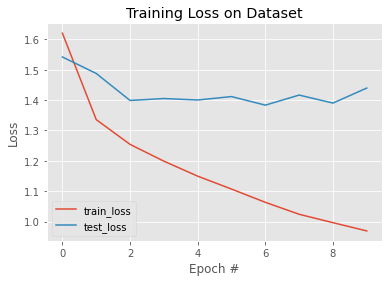

In [28]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [21]:
#torch.save(unet.state_dict(), 'model.pth')
torch.save(unet, 'Unet_AdamW.pt')

In [18]:
unet.load_state_dict(torch.load('model.pth', map_location=DEVICE))

<All keys matched successfully>

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [20]:
MASK_DATASET_PATH = "ipeo_data/alpine_label"
THRESHOLD = 10

In [65]:
def make_predictions(model, imVal, trueLabel):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
      # load the image from disk, swap its color channels, cast it
      # to float data type, and scale its pixel values
      #image = cv2.imread(imVal)
      #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      #image = image.astype("float32") / 255.0
      # resize the image and make a copy of it for visualization
      #image = cv2.resize(image, (200, 200))
      #orig = image.copy()
      # find the filename and generate the path to ground truth
      # mask
      #groundTruthPath = trueLabel
      # load the ground-truth segmentation mask in grayscale mode
      # and resize it
      #pimg = Image.open(groundTruthPath)
      #pimg = np.array(pimg)
      #gtMask = Image.fromarray(pimg*36)
          # make the channel axis to be the leading one, add a batch
      # dimension, create a PyTorch tensor, and flash it to the
      # current device
      #image = np.transpose(image, (2, 0, 1))
      #image = np.expand_dims(image, 0)
      #image = torch.from_numpy(image).to(DEVICE)
      # make the prediction, pass the results through the sigmoid
      # function, and convert the result to a NumPy array
      predMask = model(imVal).squeeze()
      print('TEST')
      #predMask = torch.sigmoid(predMask)
      predMask = predMask.cpu()
      print('TEST1')
      # filter out the weak predictions and convert them to integers
      #print((predMask>THRESHOLD)*200)
      #predMask = (predMask > THRESHOLD) * 255
      #print(predMask[0:10])
      print(predMask.shape)
      softmax = torch.nn.Softmax(dim=1)
      preds = torch.argmax(softmax(predMask),axis=1)
      print(preds.shape)
      predMask = Image.fromarray(preds[0,:,:].numpy()*36)
      print('TEST2')
      #predMask = predMask.astype(np.uint8)
      #print(predMask)
      # prepare a plot for visualization
      prepare_plot(imVal.squeeze(), trueLabel.squeeze(), predMask.squeeze())

In [29]:
test_dataset = LandCoverData(transforms=default_transform, split="test")
test_dl = DataLoader(test_dataset, BATCH_SIZE, False, num_workers=2)

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 5 5]
 [6 6 6 ... 6 5 5]]
[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
----------------
[[6 6 6 ... 0 0 0]
 [6 6 6 ... 0 0 0]
 [6 6 6 ... 0 0 0]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
[[0 0 0 ... 6 6 6]
 [0 0 0 ... 6 6 6]
 [0 0 0 ... 6 6 6]
 ...
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]]
----------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[6 6 0 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [0 0 0 ... 6 6 6]
 [0 0 0 ... 6 6 6]
 [0 0 0 ... 6 6 6]]


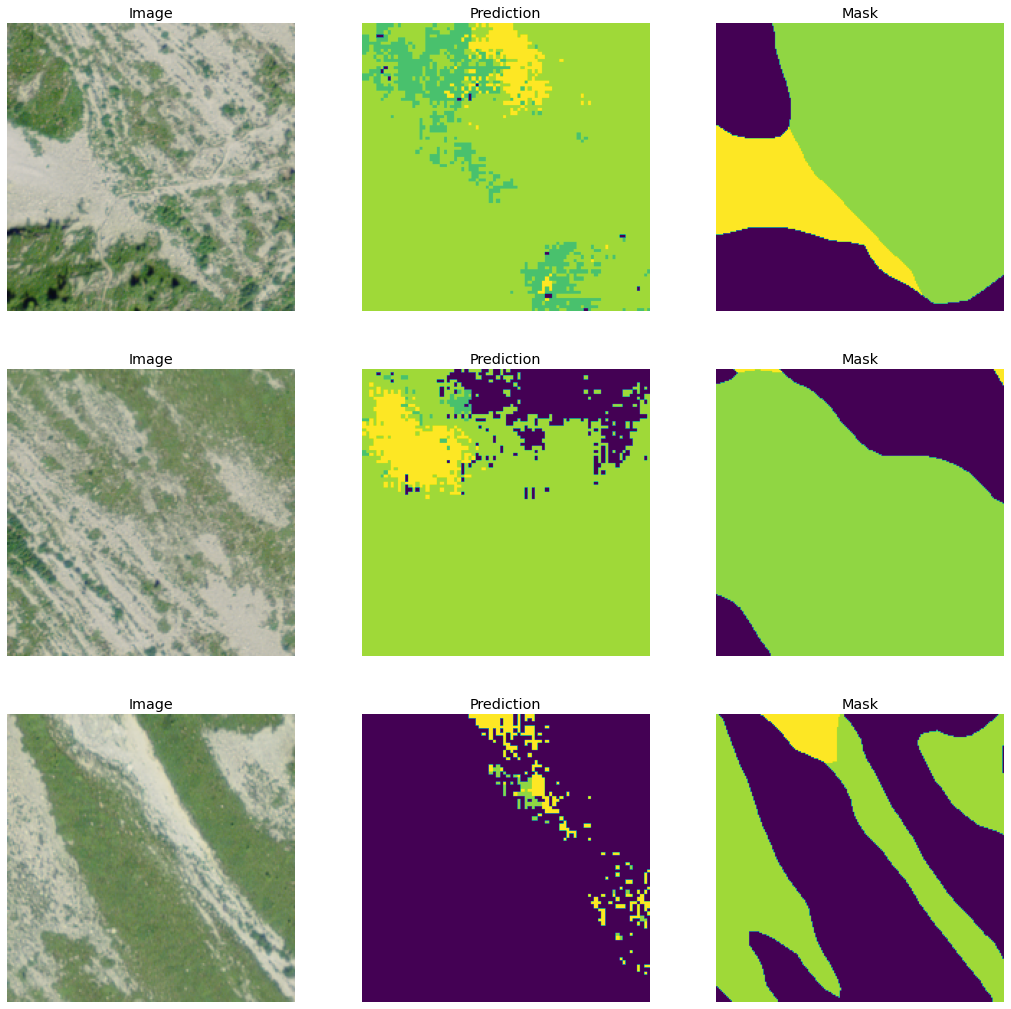

In [30]:
count = 0
for x,y in test_dl:
    y = y.to('cpu')
    y = y.squeeze()
    x = x.to('cpu')
    unet = unet.to('cpu')
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = torch.nn.Softmax(dim=1)
    #pred = unet(x)
    #probs = torch.softmax(pred, dim=1)
    #preds = torch.argmax(probs, dim=1).unsqueeze(1)
    preds = torch.argmax(softmax(unet(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3) 
    
    print(preds1)
    print(mask1)
    print('----------------')
    print(preds2)
    print(mask2)
    print('----------------')
    print(preds3)
    print(mask3)
    break

In [66]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
test_dataset = LandCoverData(transforms=default_transform, split="test")
test_dl = DataLoader(test_dataset, BATCH_SIZE, True, num_workers=2)

# iterate over the randomly selected test image paths
for x, y in test_dl:
	# make predictions and visualize the results
  make_predictions(unet, x, y)

[INFO] loading up test image paths...
TEST
TEST1
torch.Size([64, 8, 200, 200])
torch.Size([64, 200, 200])


TypeError: ignored